In [71]:
import pandas as pd
import math
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import seaborn as sns
import numpy as np
from datetime import datetime

palette_color = 'Blues_r'
colors = sns.color_palette(palette_color, as_cmap=True)
sns.set()
categs = pd.read_csv('categs.csv')[['repo','categ']]
chinese = categs.loc[categs.categ == 'chinese'].repo.values
smells = pd.read_csv('smells.csv')
files = pd.read_csv('files_info.csv')
smells = smells.loc[~smells.repo.isin(chinese)].reset_index(drop=True)

In [72]:
smells = smells.loc[(smells.smell != 'long_parameter_list') & (smells.smell != 'long_method')]
smells['categ'] = ''
for g, df in categs.groupby('repo'):
    categ = df.categ.iloc[0]
    smells.at[smells.repo == g,'categ'] = categ

# Organizing the repositories categories

In [73]:
categs_freq =smells.groupby('repo').head(1)[['categ']].value_counts().reset_index()
categs_freq.columns=['categ','nof_repos']
categs_freq

,categ,nof_repos
0,ML,43
1,utility,27
2,development,24
3,data,14
4,education,10
5,web,5
6,security,2
7,shell,1
8,python,1
9,game,1


In [74]:
top_categs = categs_freq.loc[categs_freq['nof_repos'] >= 10]
top_categs

,categ,nof_repos
0,ML,43
1,utility,27
2,development,24
3,data,14
4,education,10


In [75]:
smells = smells.loc[smells.categ.isin(top_categs.categ)]
files = files.loc[files.repo.isin(smells.repo)]

In [76]:
rf = smells[['repo','categ']].groupby('repo').head(1).reset_index(drop=True)
rdate = files.groupby('repo').head(1).reset_index(drop=True)[['repo','created_at']]
rdate.created_at = pd.to_datetime(rdate.created_at)
rdate
rdate['date'] = rdate.created_at.apply(lambda x: x.strftime('%d/%m/%Y'))
rdate=rdate[['repo','date']].reset_index(drop=True)
rdate.to_csv('temp.csv',index=False)
rdate

,repo,date
0,donnemartin/system-design-primer,26/02/2017
1,TheAlgorithms/Python,16/07/2016
2,jackfrued/Python-100-Days,01/03/2018
3,django/django,28/04/2012
4,keras-team/keras,28/03/2015
...,...,...
113,MorvanZhou/tutorials,29/05/2016
114,zalandoresearch/fashion-mnist,25/08/2017
115,deepinsight/insightface,01/09/2017
116,networkx/networkx,06/09/2010


# Explorando a quantidade de smells por categoria
* Os dois primeiros gráficos usam números absolutos apenas para fins de demonstração. A seguir no terceiro gráfico uso valores relativos.

## In order to get an overview of the dataset used, let's plot a description of the amount of repositories by category.

* It's possible to see the amount of repositories by class is unbalanced. It will be usefull on subsequent analysis.

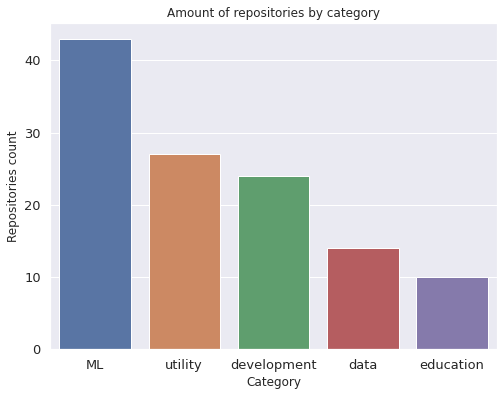

In [77]:
rcParams['figure.figsize'] = 8, 6
sns.barplot(data=top_categs,x='categ',y='nof_repos')
plt.title('Amount of repositories by category')
plt.ylabel('Repositories count')
plt.xlabel('Category')
plt.tick_params(axis='x', which='both', labelsize=13)
plt.tick_params(axis='y', which='both', labelsize=13)
plt.savefig('plots/repos_by_categs.svg',format='svg')

## Now we plot the total amount of smells on each category of repository.
* Since the amount of repositories by category is unbalanced, it's expected that the amount of smells also be unbalanced.

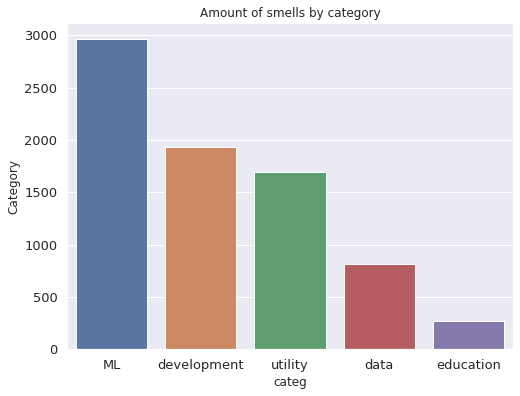

In [78]:
rcParams['figure.figsize'] = 8, 6
ss=smells[['categ']].value_counts().reset_index()
ss.columns=['categ','nof_smells']
sns.barplot(data=ss,x='categ',y='nof_smells')
plt.title('Amount of smells by category')
plt.ylabel('Smells count')
plt.ylabel('Category')
plt.tick_params(axis='x', which='both', labelsize=13)
plt.tick_params(axis='y', which='both', labelsize=13)
plt.savefig('plots/smells_by_categs.svg',format='svg')

In [79]:
ss = ss.merge(top_categs,on='categ')
ss

,categ,nof_smells,nof_repos
0,ML,2967,43
1,development,1937,24
2,utility,1697,27
3,data,817,14
4,education,268,10


## Given a class, what's the average amount of smells each repository within that class has?

* Except for the 'education' category, the average amount of smells by repository is pretty balanced. The 'education' category is composed by tutorials, which usually are composed by small snipets of code, leaving less room for introduction of smells.  Besides that, we can assert that since the average amount of smells is balanced on most of categories, it indicates us that there's no strong relationship between category and smell incidence.


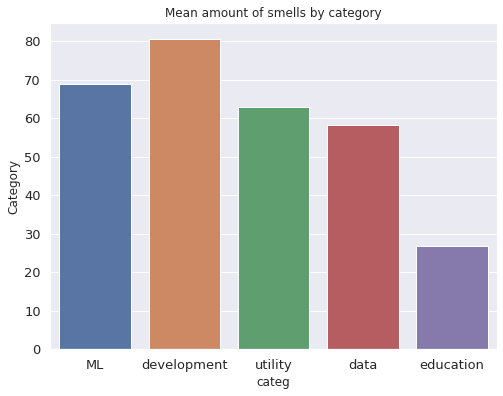

In [80]:
rcParams['figure.figsize'] = 8, 6
ss['smells_by_repo'] = ss.nof_smells/ss.nof_repos
sns.barplot(data=ss,x='categ',y='smells_by_repo')
plt.title('Mean amount of smells by category')
plt.ylabel('Mean of smells')
plt.ylabel('Category')
plt.tick_params(axis='x', which='both', labelsize=13)
plt.tick_params(axis='y', which='both', labelsize=13)
plt.savefig('plots/mean_smells_by_categs.svg',format='svg')

In [81]:
#repos = []

#for repo in smells.repo.unique():
    #repos.append({'repo':repo,'categ':None})
    #link = f'https://github.com/{repo}'
    #print(link)
#pd.DataFrame(repos).to_csv('categs.csv')

# Now we show the usual distribution of smells among all the repositories.
* It shows us that half of the samples (each sample is a repository) has at leaset 20 smells and 25% of the samples has 80 or more smells.

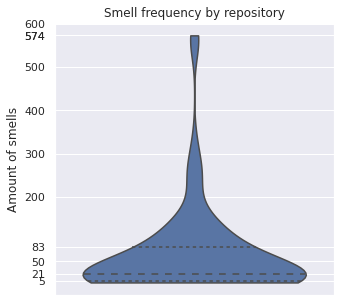

In [82]:
rcParams['figure.figsize'] = 5, 5
g = smells.groupby('repo')
g=g.size().reset_index()
g.columns=['repo','smells_count']
ax = sns.violinplot(data=g.smells_count,cut=0,inner='quartile')
plt.title('Smell frequency by repository')
plt.ylabel('Amount of smells')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


q1=g.smells_count.describe()['25%']
q2=g.smells_count.describe()['50%']
q3=g.smells_count.describe()['75%']
max_val = g.smells_count.max()
min_val = g.smells_count.max()
mean=g.smells_count.mean()

yticks = list(map(round,[min_val,q1,q2,q3,max_val]))
yticks = yticks + [50,200,300,400,500,600]
ax.set_yticks(yticks)
plt.tick_params(axis='x', which='both', labelsize=13)
plt.savefig('plots/dist_all_absolute_amount_smells.svg',format='svg')

In [83]:
repos_nof_lines = files.groupby('repo').agg('sum').reset_index().drop(columns=['score'])

In [84]:
smells_categ = smells[['repo','categ']]
smells_categ = smells_categ.drop_duplicates(subset='repo')
f = files.groupby('repo').size().reset_index()
f.columns=['repo','files']
fg = f.merge(g,on='repo')
fg['ratio'] = fg.files/fg.smells_count
fg = fg.sort_values(by='ratio',ascending=False)
fg = fg.reset_index(drop=True)
fg = fg.merge(smells_categ,on='repo')
fg = fg.merge(repos_nof_lines,on='repo')
fg['lines_ratio'] = fg.nof_lines/fg.smells_count
fg


,repo,files,smells_count,ratio,categ,nof_lines,lines_ratio
0,gunthercox/ChatterBot,133,1,133.000000,ML,13997,13997.000000
1,willmcgugan/rich,167,2,83.500000,utility,29292,14646.000000
2,MorvanZhou/tutorials,115,2,57.500000,education,5888,2944.000000
3,sanic-org/sanic,141,3,47.000000,development,25100,8366.666667
4,httpie/httpie,66,2,33.000000,development,9353,4676.500000
...,...,...,...,...,...,...,...
113,timgrossmann/InstaPy,38,40,0.950000,utility,18443,461.075000
114,psf/requests-html,5,6,0.833333,utility,1542,257.000000
115,beurtschipper/Depix,6,8,0.750000,utility,562,70.250000
116,3b1b/manim,99,135,0.733333,utility,19812,146.755556


# The distribution of smells by repository as shown on the violinplot above. Each bar represents a repository where the y axis is the amount of smells.

* We can see that few repositories have zero smells, indicating that the existence of code smells is something well spread.

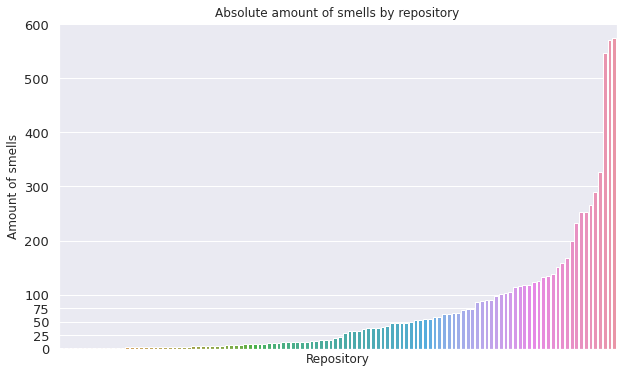

In [85]:
rcParams['figure.figsize'] = 10,6
ax = sns.barplot(data=fg.sort_values(by='smells_count'),x='repo',y='smells_count')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.title('Absolute amount of smells by repository')
plt.ylabel('Amount of smells')
plt.xlabel('Repository')
plt.tick_params(axis='y', which='both', labelsize=13)



#yticks = [0,25,50,75,100,125,150,175,200,250,300,400,500,fg.smells_count.max(),600]
yticks = [0,25,50,75,100,200,300,400,500,600]
ax.set_yticks(yticks)
plt.savefig('plots/individual_repos_amount_smells.svg',format='svg')

# Given a repository, on average, how many smells by source file it has? Each bar is a repository and the y axis is the amount of smells per file the given repository has.
* On the plot below we can see the same data ploted on violin plot which gives us more statistical info.

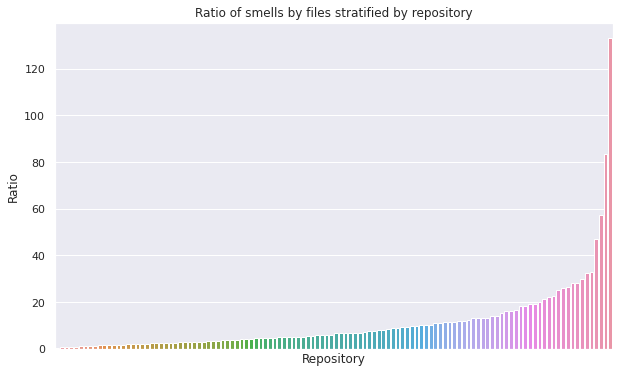

In [86]:
rcParams['figure.figsize'] = 10,6
sns.barplot(data=fg.sort_values(by='ratio'),x='repo',y='ratio')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.title('Ratio of smells by files stratified by repository')
plt.ylabel('Ratio')
plt.xlabel('Repository')
plt.savefig('plots/individual_smells_by_file.svg',format='svg')

# Given a repository, on average, how many files does it take to a smell to show up?
* We can see that hald the repositories takes on average seven files to show a single smell. In other words: each seven files, there's a smell.

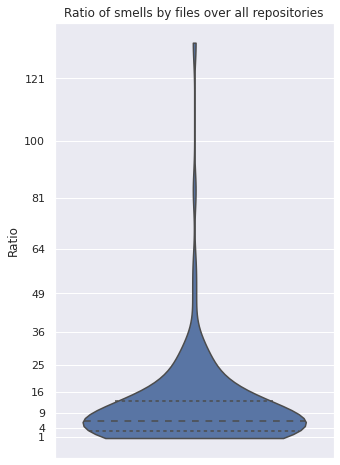

<Figure size 360x576 with 0 Axes>

In [87]:
rcParams['figure.figsize'] = 5,8
yticks = [i*i for i in list(range(0,13))]
yticks=yticks[1:-1]
#yticks = np.linspace(0,2,15,np.float)
ax = sns.violinplot(data=fg.sort_values(by='ratio'),y='ratio',cut=0,inner='quartile')
ax.set_yticks(yticks)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.title('Ratio of smells by files over all repositories')
plt.ylabel('Ratio')
plt.xlabel(None)
plt.show()
plt.savefig('plots/dist_individual_repos_amount_smells.svg',format='svg')

# How many lines, on average, does it takes to a single smell to show up?
* Each bar represents a repository, the y axis represents the amount of lines, on average, it takes to a single smell to show up.

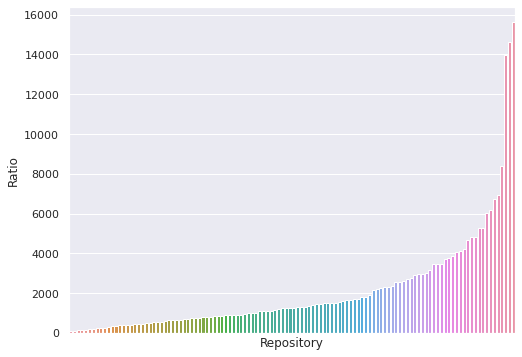

In [88]:
rcParams['figure.figsize'] = 8,6
sns.barplot(data=fg.sort_values(by='lines_ratio'),x='repo',y='lines_ratio')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
#plt.title('Ratio of smells by lines of code stratified by repository')
plt.ylabel('Ratio')
plt.xlabel('Repository')
plt.savefig('plots/individual_repos_amount_smells.svg',format='svg')

# How many lines does it take to a single smell to show up.
* Half the samples takes around 1500 lines of code to present a single smell. In this distribution, the higher the number, the better the result.

Text(0.5, 0, '')

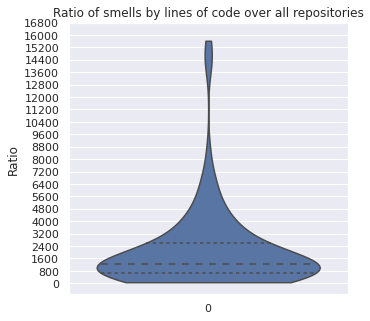

In [89]:
rcParams['figure.figsize'] = 5,5
yticks = range(0,17000,800)
ax = sns.violinplot(data=fg.lines_ratio,cut=0,inner='quartile')
ax.set_yticks(yticks)
plt.title('Ratio of smells by lines of code over all repositories')
plt.ylabel('Ratio')
plt.xlabel(None)

# Visualizing the distributions over the categories

## The amount of smells on each repository category.
* Using the quartils as reference, we can see that ML, utility and the data category has are quite similar, meaning the repositories inside these classes have similar smells amount distribution. But when checking the development category, we can see it's distribution is shifted up, specially on the first two quartils, which floats around 5 smells per repository.

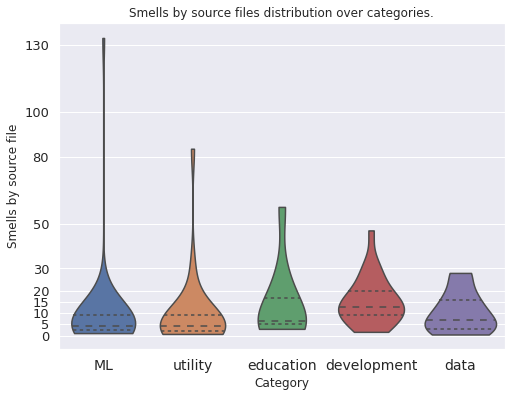

In [90]:
rcParams['figure.figsize'] = 8,6

yticks = [i for i in range(0,40, 10)]
yticks2 = [i for i in range(40,150, 30)]
yticks = yticks + yticks2
yticks = [0,5,10,15,20,30,50,80,100,130]
ax = sns.violinplot(data=fg,x='categ',y='ratio',cut=0,inner='quartile')
ax.set_yticks(yticks)
plt.title('Smells by source files distribution over categories.')
plt.tick_params(axis='x', which='both', labelsize=14)
plt.tick_params(axis='y', which='both', labelsize=13)
plt.xlabel('Category')
plt.ylabel('Smells by source file')
plt.savefig('plots/dist_categorized_smells_by_source.svg',format='svg')

* A distribuição de smells por linha de código se demonstra consistente no segundo quartil.

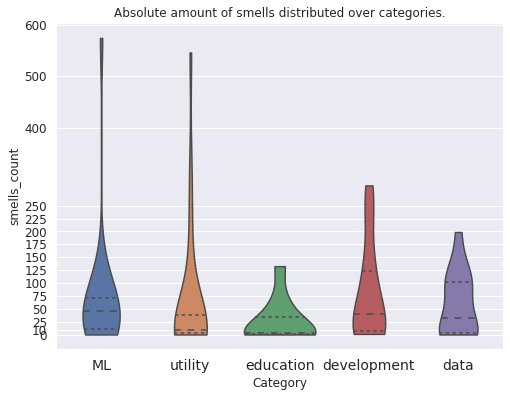

<Figure size 576x432 with 0 Axes>

In [91]:
rcParams['figure.figsize'] = 8,6

yticks2 = [i for i in range(200,1000, 200)]
yticks = [0,10,25,50,75,100,125,150,175,200,225,250]+[400,500,600]
ax = sns.violinplot(data=fg,x='categ',y='smells_count',cut=0,inner='quartile')
ax.set_yticks(yticks)
plt.title('Absolute amount of smells distributed over categories.')
plt.tick_params(axis='x', which='both', labelsize=14)
plt.tick_params(axis='y', which='both', labelsize=12)
plt.xlabel('Category')
plt.show()
plt.savefig('plots/dist_smells_by_category.svg',format='svg')

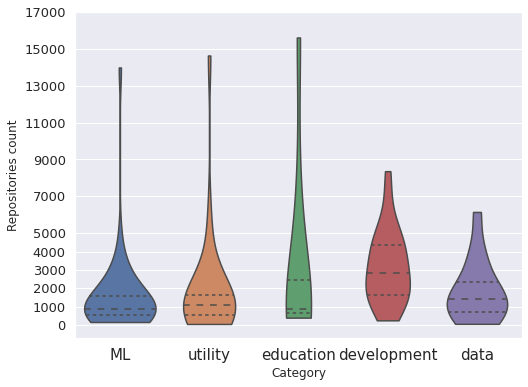

In [92]:
rcParams['figure.figsize'] = 8,6
ax = sns.violinplot(data=fg,x='categ',y='lines_ratio',cut=0,inner='quartile')
#plt.title('Distribution of the smells by lines.')
#plt.title('Amount of repositories by category')
plt.ylabel('Repositories count')
plt.xlabel('Category')
plt.tick_params(axis='x', which='both', labelsize=15)
plt.tick_params(axis='y', which='both', labelsize=13)

yticks = list(range(0,5000,1000))
yticks = yticks + list(range(5000,19000,2000))
#yticks = yticks + [50,200,300,400,500,600]
ax.set_yticks(yticks)
plt.savefig('plots/dist_categorized_smells_lines.svg',format='svg')

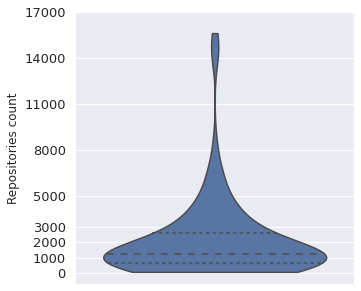

In [93]:
rcParams['figure.figsize'] = 5,5
ax = sns.violinplot(data=fg,y='lines_ratio',cut=0,inner='quartile')
#plt.title('Distribution of the smells by lines.')
#plt.title('Amount of repositories by category')
plt.ylabel('Repositories count')
plt.tick_params(axis='x', which='both', labelsize=15)
plt.tick_params(axis='y', which='both', labelsize=13)

yticks = list(range(0,4000,1000))
yticks = yticks + list(range(5000,19000,3000))
ax.set_yticks(yticks)
plt.savefig('plots/dist_smells_lines.svg',format='svg')

In [94]:
fg

,repo,files,smells_count,ratio,categ,nof_lines,lines_ratio
0,gunthercox/ChatterBot,133,1,133.000000,ML,13997,13997.000000
1,willmcgugan/rich,167,2,83.500000,utility,29292,14646.000000
2,MorvanZhou/tutorials,115,2,57.500000,education,5888,2944.000000
3,sanic-org/sanic,141,3,47.000000,development,25100,8366.666667
4,httpie/httpie,66,2,33.000000,development,9353,4676.500000
...,...,...,...,...,...,...,...
113,timgrossmann/InstaPy,38,40,0.950000,utility,18443,461.075000
114,psf/requests-html,5,6,0.833333,utility,1542,257.000000
115,beurtschipper/Depix,6,8,0.750000,utility,562,70.250000
116,3b1b/manim,99,135,0.733333,utility,19812,146.755556


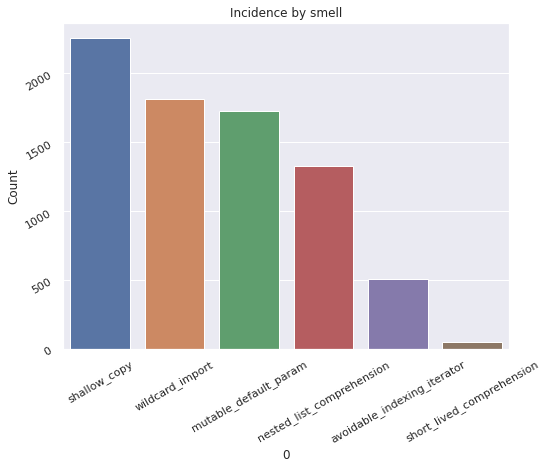

In [95]:
rcParams['figure.figsize'] = 8, 6
dd=smells.smell.value_counts()
plt.title('Incidence by smell')
plt.ylabel('Count')
dd = pd.DataFrame(list(dd.items())).T
dd.columns = dd.iloc[0]
dd = dd.iloc[[1]]
ax = sns.barplot(data=dd)
ax.tick_params(rotation=30)

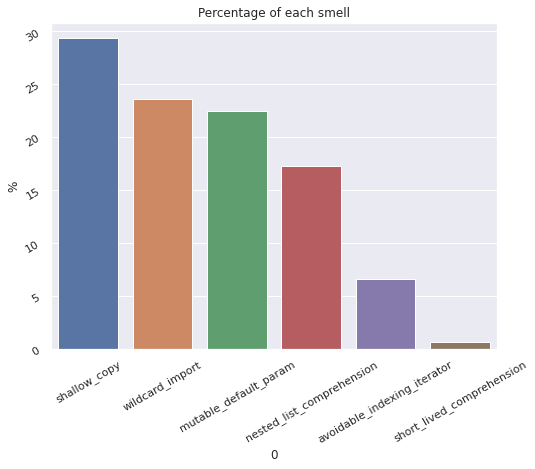

In [109]:
rcParams['figure.figsize'] = 8, 6
dd=smells.smell.value_counts()
maximum = dd.sum()
plt.title('Percentage of each smell')
plt.ylabel('%')
dd = pd.DataFrame(list(dd.items())).T
dd.columns = dd.iloc[0]
dd = dd.iloc[[1]]
dd=100*(dd/maximum)
ax = sns.barplot(data=dd)
ax.tick_params(rotation=30)

# Is it common to a repository to contain more then one kind of smell?
* we have 6 kinds of smells categorized, so in order to answer this question we bined the repositories using as reference the incidence of each kind of smell on the repository.
* The x axis is the amount of smell category incidence (ranging from 1 to 6).
* The y axis is the amount of repositories which falls into the bin.

# Is it common to a repository to contain more then one kind of smell?
* The same plot above, but now in percentage
* At least 12% of the repositories contains all the possible smells
* Around 30% contains 5 or 6 smells
* Around 40% of the repositories contains smells across 4 different categories!
* It shows us that those smells are well spread among the repositires, which making those repositories succesptible to different kind of unexpected behaviors.  It's a good indicator that the code smell problem is an live and ongoing problem on many applications.

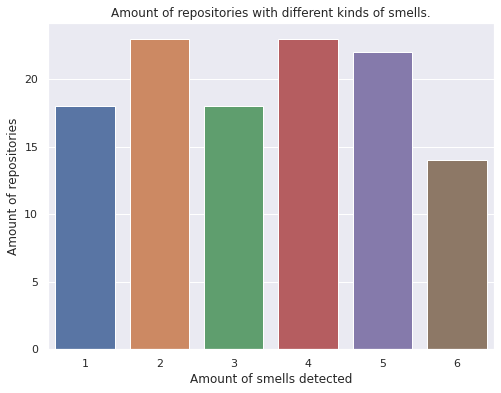

In [97]:
rcParams['figure.figsize'] = 8,6
g = smells.groupby(['repo','smell']).size().reset_index()
g.columns=['repo','smell','count']
f=g.repo.value_counts().reset_index()
f.columns=['repo','categories']
f=f.categories.value_counts().reset_index()
f.columns=['smells_amount','frequency']
f=f.sort_values(by='smells_amount')
sns.barplot(data=f,x='smells_amount',y='frequency')
plt.title('Amount of repositories with different kinds of smells.')
plt.xlabel('Amount of smells detected')
plt.ylabel('Amount of repositories')
plt.savefig('plots/smells_cumulation.svg',format='svg')

/home/ndc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


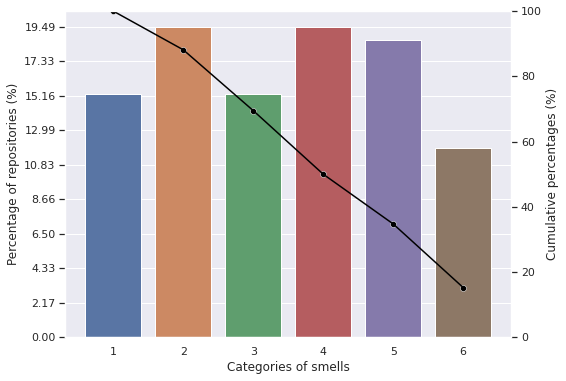

[1.0,
 0.8813559322033899,
 0.6949152542372882,
 0.5,
 0.3474576271186441,
 0.15254237288135594]

In [98]:
g = smells.groupby(['repo','smell']).size().reset_index()
g.columns=['repo','smell','count']
f=g.repo.value_counts().reset_index()
f.columns=['repo','categories']
f=f.categories.value_counts().reset_index()
f.columns=['smells_amount','frequency']
f=f.sort_values(by='smells_amount')
f_sum = f.frequency.sum()
f.frequency = 100*f.frequency/f_sum
yticks = np.linspace(0,f.frequency.max(),10,np.float)




fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.grid(b=None)

y_max = f.frequency.max()
ax2_ticks_labels = yticks/f.frequency.max()*100
ax2_ticks_labels = [str(int(i)) for i in ax2_ticks_labels]
ax2.set_ylim(ax.get_ylim()) # set second y axis to have the same limits as the first y axis
#ax2.set_yticks(ax2_ticks) 
ax2.set_yticklabels([str(int(round(i*100))) for i in ax2.get_yticks()])


sns.barplot(data=f,x='smells_amount',y='frequency',ax=ax)

ax.set_yticks(yticks)
#plt.title('Percentage of repositories with different kinds of smells.')
plt.xlabel('Incidency of smell categories')

f.frequency = f.frequency/100

f[['frequency']].expanding().sum()
f['sum'] = f[['frequency']].expanding().sum()

sums = list(f['sum'].values)[::-1]
sns.scatterplot(data=sums,color='black',ax=ax2)
sns.lineplot(data=sums,color='black',ax=ax2)

ax.set_ylabel('Percentage of repositories (%)')
ax2.set_ylabel('Cumulative percentages (%)')
ax.set_xlabel('Categories of smells')
plt.show()
fig.savefig('plots/frequency_smells_cumulation.svg',format='svg')
sums

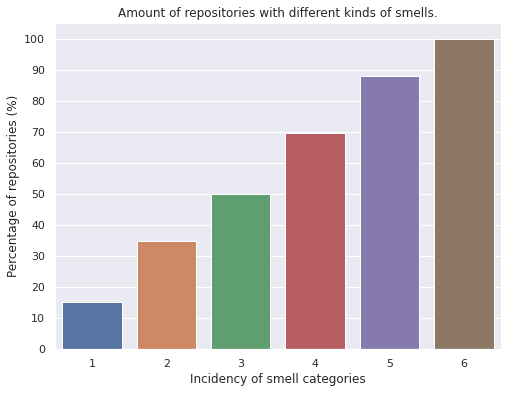

In [99]:
f[['frequency']].expanding().sum()
f['sum'] = f[['frequency']].expanding().sum()*100
yticks = np.linspace(0,100,11,np.float)
ax = sns.barplot(data=f,x='smells_amount',y='sum')
ax.set_yticks(yticks)
plt.title('Amount of repositories with different kinds of smells.')
plt.xlabel('Incidency of smell categories')
plt.ylabel('Percentage of repositories (%)')
plt.savefig('plots/sum_frequency_smells_cumulation.svg',format='svg')

In [100]:
smells_by_repo = pd.DataFrame(smells.groupby('repo').size()).reset_index()
smells_by_repo.columns=['repo','smells']
smells_by_repo=smells_by_repo.sort_values(by='smells',ascending=False)
smells_by_repo

,repo,smells
63,huggingface/transformers,574
6,PaddlePaddle/Paddle,570
15,XX-net/XX-Net,546
84,networkx/networkx,327
60,home-assistant/core,289
...,...,...
65,isocpp/CppCoreGuidelines,1
103,satwikkansal/wtfpython,1
58,gunthercox/ChatterBot,1
57,gto76/python-cheatsheet,1


In [101]:
lines_by_repo = files[['repo','nof_lines']].groupby('repo').sum().reset_index()
lines_by_repo = lines_by_repo.sort_values(by='nof_lines').reset_index(drop=True)
lines_by_repo

,repo,nof_lines
0,beurtschipper/Depix,562
1,zalandoresearch/fashion-mnist,665
2,satwikkansal/wtfpython,676
3,donnemartin/system-design-primer,1088
4,psf/requests-html,1542
...,...,...
113,pandas-dev/pandas,506806
114,PaddlePaddle/Paddle,509300
115,XX-net/XX-Net,599709
116,home-assistant/core,1004627


In [102]:
df = pd.merge(smells_by_repo, lines_by_repo, on='repo', how='outer').fillna(0)
df['rate'] = df.smells/df.nof_lines
df = df.loc[df.rate != np.inf].sort_values(by='rate',ascending=False)

In [103]:
df

,repo,smells,nof_lines,rate
76,beurtschipper/Depix,8,562,0.014235
39,tzutalin/labelImg,55,4229,0.013005
88,zalandoresearch/fashion-mnist,5,665,0.007519
14,3b1b/manim,135,19812,0.006814
65,asciinema/asciinema,13,2032,0.006398
...,...,...,...,...
75,aio-libs/aiohttp,8,55305,0.000145
102,sanic-org/sanic,3,25100,0.000120
115,gunthercox/ChatterBot,1,13997,0.000071
104,willmcgugan/rich,2,29292,0.000068


# Explorando a idade dos repositórios

In [104]:
import pytz

files.created_at = pd.to_datetime(files.created_at)
now = datetime.now(tz=pytz.UTC)
repo_created_at = files[['repo','created_at']].groupby('repo').head(1)
repo_created_at['age'] = now-repo_created_at.created_at
repo_created_at['age'] = repo_created_at.age.apply(lambda x: x.days)
repo_created_at['years'] = (repo_created_at['age']/365).apply(math.floor)

repo_created_at = repo_created_at[['repo','age','years']]
repo_created_at
df = df.merge(repo_created_at,on='repo')
df

,repo,smells,nof_lines,rate,age,years
0,beurtschipper/Depix,8,562,0.014235,173,0
1,tzutalin/labelImg,55,4229,0.013005,2080,5
2,zalandoresearch/fashion-mnist,5,665,0.007519,1372,3
3,3b1b/manim,135,19812,0.006814,2258,6
4,asciinema/asciinema,13,2032,0.006398,3475,9
...,...,...,...,...,...,...
113,aio-libs/aiohttp,8,55305,0.000145,2795,7
114,sanic-org/sanic,3,25100,0.000120,1828,5
115,gunthercox/ChatterBot,1,13997,0.000071,2434,6
116,willmcgugan/rich,2,29292,0.000068,565,1


## Validating the repository age distribution to assert the dataset is well spread

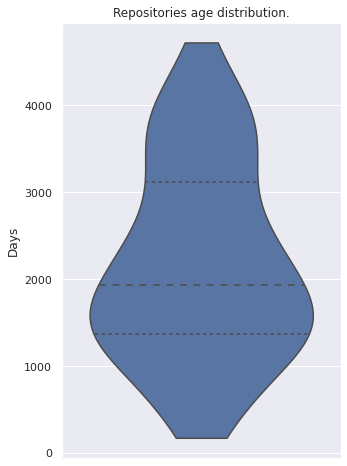

In [105]:
rcParams['figure.figsize'] = 5,8
sns.violinplot(data=df.age,inner='quartile',cut=0)
plt.title('Repositories age distribution.')
plt.ylabel('Days')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Is there any correlation on the smells and the repository age?
* From the plots below, we can see there's no clear correlation between repository age and smells incidency.
* Since there's no increase or decrease tendency over the time, then it lead us to the conclusion that the developers pratices aren't changing over the time on regard of code smells.
* Perhaps these pratices aren't changing due to the lack of indicators, or even a catalog to those more specific smells.

Text(0.5, 1.0, 'Relation between repository age and amount of smells')

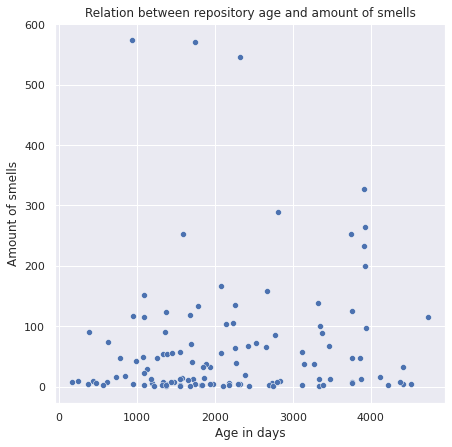

In [106]:
rcParams['figure.figsize'] = 7,7
sns.scatterplot(data=df,x='age',y='smells')
plt.xlabel('Age in days')
plt.ylabel('Amount of smells')
plt.title('Relation between repository age and amount of smells')

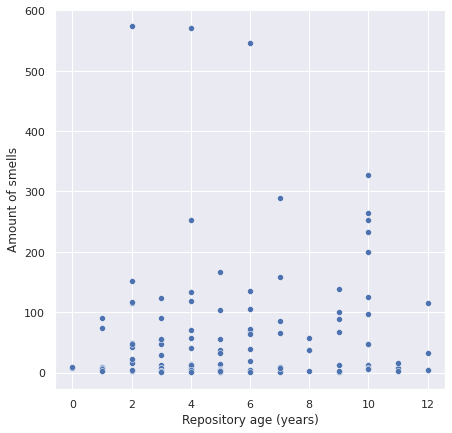

In [107]:
ax = sns.scatterplot(data=df,x='years',y='smells')
plt.xlabel('Repository age (years)')
plt.ylabel('Amount of smells')
#plt.title('Repositories age')
plt.savefig('plots/repos_age.svg',format='svg')

## Não exitem nenhuma tendência de crescimento ou decrescimento na quantidade de smells por idade
* Isto indica que as práticas de desenvolvimento que geram o surgimento destes smells são mantidas há anos e nunca foram abandonadas/alteradas

Text(0, 0.5, 'Amount of smells (mean)')

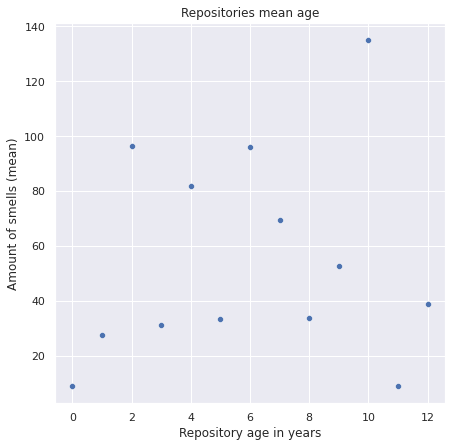

In [108]:
f=df.groupby('years').agg('mean').reset_index()
sns.scatterplot(data=f,x='years',y='smells')
plt.title('Repositories mean age')
plt.xlabel('Repository age in years')
plt.ylabel('Amount of smells (mean)')

* Estratificar os tipos de repositórios (mobile, IA, etc)
* Evitar números absolutos
* Exibir incidência de múltiplos smells por repositórios e categoria de repositórios
* Usar beanplot
* Começar o paper a partir do roteiro (quero provar isso e para provar eu fiz isso, de tal forma e com tal ferramenta, tendo resultados assim e assim) [Contexto, Problema, solução e avaliação]
* Contexto: Covid surgiu. Problema: Tá todo mundo morrendo. Solução: proposta da vacina. Avaliação: testes resultados da vacina.


* Corrigir as labels e explicar os gráficos
* Trazer insights para cada gráfico/correlação
* Escrever o motivating example